# Gaussian process regression



In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

In [2]:
sns.set(style="white")

Gaussian processes are formally defined to be _a collection of random variables, any Gaussian process finite number of which have a joint Gaussian distribution._, but that might not be terribly informative until you have thought about it for a while.

I personally find this rather abstract. But if we ignore the details, what this says that if I have a set of points, I can generate a function by drawing realisations from a multi-variate Gaussian with a covariance function that we need to specify and normally set to have a mean of zero.

The most commonly used covariance function is what is called the squared exponential in this area, defined through

$$\text{Cov}\left (x, x^\prime\right) = K(x, x^\prime) = \exp\left(-\frac{\left|x-x^\prime\right|}{2h} \right) $$

It is now straight forward to draw random functions with this covariance function. We simply draw from a multivariate Gaussian with mean of zero with the covariance function. To follow the notation of Rasmussen & Williams we say that the values of the function are drawn from $N(0, K(X_*, X_*))$, where $X_*$ are the test sample, or rather the x-values where we want to evaluate the function. This covariance function provides the prior on the functions we will explore.

In [3]:
def covariance_function(x, xprime, h=1.0):
    """
    A squared exponential covariance function. Since this is for
    illustration purposes, I will only allow 1D input.
    """
    n_x = len(x)
    n_xprime = len(xprime)
    
    X1 = x[:,np.newaxis].repeat(n_xprime, axis=1)
    X2 = xprime[np.newaxis].repeat(n_x, axis=0)
    
    dist = (X1-X2)**2
    return np.exp(-0.5*dist/h)

def draw_function(x, n=1, h=1.0):
    
    cov = covariance_function(x, x, h=h)
    mean = np.zeros(len(x))
    
    fvals = np.random.multivariate_normal(mean, cov, size=n)
    
    return fvals.T
    
    

In [4]:
x = np.linspace(-5, 5, 100)
y_free = draw_function(x, n=4, h=1)

Text(0, 0.5, 'y')

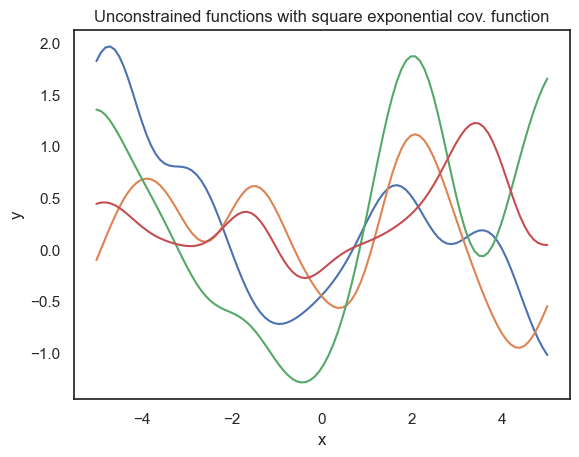

In [5]:
plt.plot(x, y_free)
plt.title('Unconstrained functions with square exponential cov. function')
plt.xlabel('x')
plt.ylabel('y')

Now we want to place some constraints on the functions. I will not go through this in detail, but the idea is basically that we use the prior as before, and then multiply with the likelihood of the data in much the same way as we did in earlier lectures.

The multiplication of two Gaussians is again a Gaussian (and thence a Gaussian process) and with some arithmetics it is possible to show that the posterior distribution of the function, $p(y_*|X_*, X, y)$ is distributed as a Gaussian with a mean $\mu$ and covariance $C$ given by:

$$\mu = K(X_*, X) K(X, X)^{-1} y$$

and 

$$C = K(X_*, X_*) - K(X_*, X) K(X, X)^{-1} K(X, X_*) $$

where $K(\cdot, \cdot)$ is the kernel as above. $X$ is the matrix of observables and $y$ the vector of responses. In a 1D case, as considered here, $X$ is a vector of x-values and $y$ a vector of measurements.

In [6]:
def draw_constrained_functions(x_obs, y_obs, x, n=1, h=1.0):
    
    # This implements equation 2.19 from Rasmussen & Williams (2006)
    
    # First calculate the training sample covariance matrix. We need
    # the inverse of this.
    cov_train = covariance_function(x_obs, x_obs, h=h)
    inv_cov_train = np.linalg.inv(cov_train)
    
    # The the test-test and test-training covariances
    
    cov_testtest = covariance_function(x, x, h=h)
    cov_testtrain = covariance_function(x, x_obs, h=h)
    cov_traintest = covariance_function(x_obs, x, h=h)
    
    # This matrix is needed twice so I pre-calculate it here.
    Ktmp = np.matmul(cov_testtrain, inv_cov_train)
    mean = np.matmul(Ktmp, y_obs)
    cov = cov_testtest - np.matmul(Ktmp, cov_traintest)
    
    fvals = np.random.multivariate_normal(mean, cov, size=n)
    
    return fvals.T
    

In [7]:
x_obs = np.array([-3, 0.5, 2.1])
y_obs = np.array([-0.5, 1, 0.9])

In [8]:
y = draw_constrained_functions(x_obs, y_obs, x, n=4, h=2.)

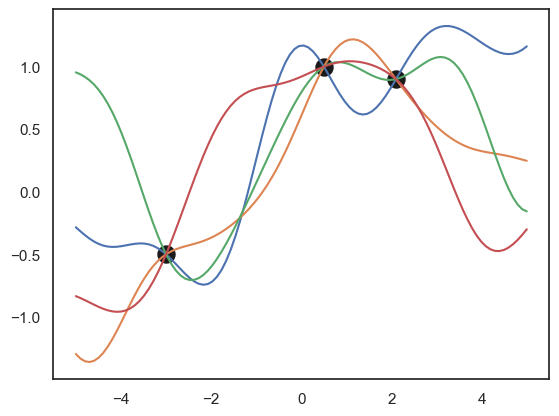

In [9]:
plt.plot(x, y)
plt.scatter(x_obs, y_obs, 150, 'k')

Finally, we would also like to be able to include an uncertainty on the points - above it was assumed that there was no noise. In this case there is an extra term in the sample covariance matrix and the predictive distribution is a Gaussian with mean, $\mu$, and covariance $C$ given by

$$\mu = K(X_*, X)\left[K(X, X) + \sigma_n^2 I\right]^{-1} y = K(X_*, X) A^{-1} y $$

where $I$ is the identity matrix and $\sigma_n$ is the uncertainty on each point (assumed constant), and 

$$C = K(X_*, X_*) - K(X_*, X) A^{-1} K(X, X_*) $$

So very similar in form to the previous case. Modifying our function from before we then have (notice that I also modified the code to return the trace of the covariance matrix to get a confidence band).

In [10]:
def draw_constrained_functions_w_noise(x_obs, y_obs, dy_obs, x, n=1, h=1.0):
    
    # This implements equation 2.22-2.24 from Rasmussen & Williams (2006)
    
    # First calculate the training sample covariance matrix plus the noise
    # covariance. We need the inverse of this.
    cov_noise = np.diag(dy_obs) # Assume independence
    cov_train = covariance_function(x_obs, x_obs, h=h) + cov_noise
    inv_cov_train = np.linalg.inv(cov_train)
    
    # The the test-test and test-training covariances
    
    cov_testtest = covariance_function(x, x, h=h)
    cov_testtrain = covariance_function(x, x_obs, h=h)
    cov_traintest = covariance_function(x_obs, x, h=h)
    
    # This matrix is needed twice so I pre-calculate it here.
    Ktmp = np.matmul(cov_testtrain, inv_cov_train)
    mean = np.matmul(Ktmp, y_obs)
    cov = cov_testtest - np.matmul(Ktmp, cov_traintest)
    
    fvals = np.random.multivariate_normal(mean, cov, size=n)
    
    return fvals.T, np.diag(cov)

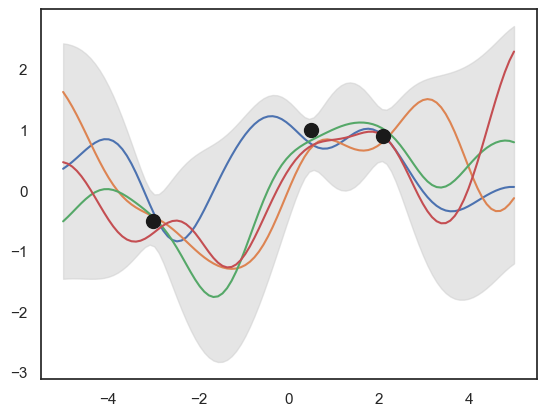

In [11]:
sigma_y  = 0.05+np.zeros(len(y_obs))
y, var_y = draw_constrained_functions_w_noise(x_obs, y_obs, sigma_y, x, n=4)
ylow = np.mean(y, axis=1)-1.96*np.sqrt(var_y)
yhigh =np.mean(y, axis=1)+1.96*np.sqrt(var_y)

plt.plot(x, y)
plt.fill_between(x, ylow, yhigh, alpha=0.5, color='#cccccc')
tmp = plt.errorbar(x_obs, y_obs, sigma_y, fmt='.k', ecolor='gray', markersize=20)

Next we will now try a proper Gaussian Process Regression package - namely the one in `sklearn`.

In [12]:
def make_fake_data():
    """
    Create some data from a sine curve.
    """
    
    np.random.seed(15)
    
    n_samples = 7
    
    x = np.random.uniform(-1, 1.5, 10)*np.pi
    x.sort()
    
    y = np.sin(x)
    
    # And finally add some noise
    dy = 1.0/3.0
    y = y + np.random.normal(0, dy, len(y))
    
    return x, y, dy

def plot_a_fit(x, y, dy, xest, yest, dyest, include_true=False):
    """
    Plot the result of a fit to the fake data. This is put in as a function
    to speed things up below.
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(xest, yest, '-k')
    y_low = yest - 1.96*dyest
    y_high = yest + 1.96*dyest
    ax.fill_between(xest, y_low, y_high, alpha=0.2, color='r')
    ax.errorbar(x, y, dy, fmt='.k', ecolor='gray', markersize=8)
    plt.plot(xest, yest, '-', color='#00aaff')
    
    if include_true:
        plt.plot(xest, np.sin(xest), '--', color='#999999')

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [17]:
x, y, dy = make_fake_data()
xplot = np.linspace(np.min(x), np.max(x), 1000)
yplot = np.sin(xplot)

In [18]:
gp = GaussianProcessRegressor(kernel=RBF(0.1),
                              alpha=(dy/y)**2)

The `alpha` option provides a way to give the uncertainty on $y$ to the procedure.

In [19]:
g = gp.fit(x[:, np.newaxis], y)

In [25]:
y_pred, sigma = gp.predict(xplot[:, np.newaxis], return_std=True)

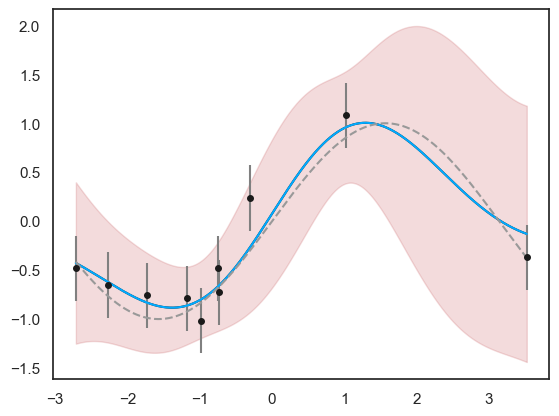

In [26]:
plot_a_fit(x, y, dy, xplot, y_pred, sigma, include_true=True)